In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
import joblib
import warnings
warnings.filterwarnings('ignore')

# ── Steam-themed plot style ──
STEAM_DARK  = '#0a0e1a'
STEAM_MID   = '#1b2838'
STEAM_PANEL = '#2a475e'
STEAM_BLUE  = '#66c0f4'
STEAM_BRIGHT= '#89d4ff'
STEAM_LIGHT = '#c7d5e0'
STEAM_GREEN = '#4ade80'
STEAM_AMBER = '#fbbf24'

plt.rcParams.update({
    'figure.facecolor': STEAM_DARK, 'axes.facecolor':   STEAM_PANEL,
    'axes.edgecolor':   STEAM_BLUE, 'axes.labelcolor':  STEAM_LIGHT,
    'xtick.color':      STEAM_LIGHT,'ytick.color':      STEAM_LIGHT,
    'text.color':       STEAM_LIGHT,'grid.color':       '#3d5a73',
    'font.family':      'DejaVu Sans','axes.titlesize':  14,
    'axes.titleweight': 'bold',     'figure.dpi':       120,
})
print(' Libraries loaded.')

STEAM_BLUE  = '#66c0f4'
STEAM_BRIGHT= '#89d4ff'
STEAM_LIGHT = '#c7d5e0'
STEAM_GREEN = '#4ade80'
STEAM_AMBER = '#fbbf24'

plt.rcParams.update({
    'figure.facecolor': STEAM_DARK, 'axes.facecolor':   STEAM_PANEL,
    'axes.edgecolor':   STEAM_BLUE, 'axes.labelcolor':  STEAM_LIGHT,
    'xtick.color':      STEAM_LIGHT,'ytick.color':      STEAM_LIGHT,
    'text.color':       STEAM_LIGHT,'grid.color':       '#3d5a73',
    'font.family':      'DejaVu Sans','axes.titlesize':  14,
    'axes.titleweight': 'bold',     'figure.dpi':       120,
})
print(' Libraries loaded.')


 Libraries loaded.
 Libraries loaded.


In [7]:
# Load ENTIRE dataset — no .head() limit
games_raw = pd.read_csv('games.csv')
print(f'Full dataset shape : {games_raw.shape}')
print(f'Columns            : {list(games_raw.columns)}')
print(f'Memory usage       : {games_raw.memory_usage(deep=True).sum() / 1e6:.1f} MB')
games_raw.head(3)


Full dataset shape : (50872, 13)
Columns            : ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']
Memory usage       : 12.4 MB


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True


In [8]:
# ── Missing Value Analysis ──
missing     = games_raw.isnull().sum()
missing_pct = (missing / len(games_raw) * 100).round(2)
missing_df  = pd.DataFrame({'Count': missing, '%': missing_pct})
missing_df  = missing_df[missing_df['Count'] > 0].sort_values('%', ascending=False)

print('=== Missing Value Report ===')
print(missing_df if not missing_df.empty else 'No missing values.')

if not missing_df.empty:
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.barh(missing_df.index, missing_df['%'], color=STEAM_BLUE, edgecolor=STEAM_DARK)
    ax.set_xlabel('Missing (%)')
    ax.set_title('Figure 1: Missing Value Analysis per Column')
    for bar, val in zip(bars, missing_df['%']):
        ax.text(bar.get_width()+0.1, bar.get_y()+bar.get_height()/2, f'{val}%', va='center', fontsize=9)
    plt.tight_layout()
    plt.savefig('fig01_missing_values.png', bbox_inches='tight')
    plt.show()


=== Missing Value Report ===
No missing values.


In [9]:
games = games_raw.copy()

# 1. Fill missing values
games['positive_ratio'] = games['positive_ratio'].fillna(0)
games['user_reviews']   = games['user_reviews'].fillna(0)
games['price_final']    = games['price_final'].fillna(0)
games['rating']         = games['rating'].fillna('Unknown')

# 2. Standardise column name
if 'AppID' in games.columns and 'app_id' not in games.columns:
    games.rename(columns={'AppID': 'app_id'}, inplace=True)

# 3. Outlier removal — IQR x3 on price
Q1, Q3 = games['price_final'].quantile(0.25), games['price_final'].quantile(0.75)
IQR = Q3 - Q1
before = len(games)
games = games[games['price_final'] <= Q3 + 3 * IQR].copy()
print(f'Rows removed (price outliers): {before - len(games)}')

# 4. Min-Max normalisation
scaler = MinMaxScaler()
games[['positive_ratio_norm','user_reviews_norm','price_norm']] = scaler.fit_transform(
    games[['positive_ratio','user_reviews','price_final']]
)

# 5. Ordinal rating encoding
rating_map = {
    'Overwhelmingly Positive':6,'Very Positive':5,'Mostly Positive':4,
    'Mixed':3,'Mostly Negative':2,'Very Negative':1,
    'Overwhelmingly Negative':0,'Unknown':2
}
games['rating_score'] = games['rating'].map(rating_map).fillna(3)

# 6. Platform columns
plat_cols = [c for c in ['win','mac','linux'] if c in games.columns]

# 7. Price tier
games['price_tier'] = pd.cut(
    games['price_final'],
    bins=[-0.01,0,5,15,30,60,10000],
    labels=['free','budget','mid','standard','premium','luxury']
).astype(str)

games = games.reset_index(drop=True)
print(f'\n Cleaned dataset: {games.shape}')
print(f'Memory: {games.memory_usage(deep=True).sum()/1e6:.1f} MB')
print(games['rating'].value_counts())


Rows removed (price outliers): 804

 Cleaned dataset: (50068, 18)
Memory: 16.5 MB
rating
Positive                   13393
Very Positive              12911
Mixed                      11911
Mostly Positive             8574
Mostly Negative             1817
Overwhelmingly Positive     1092
Negative                     297
Very Negative                 59
Overwhelmingly Negative       14
Name: count, dtype: int64


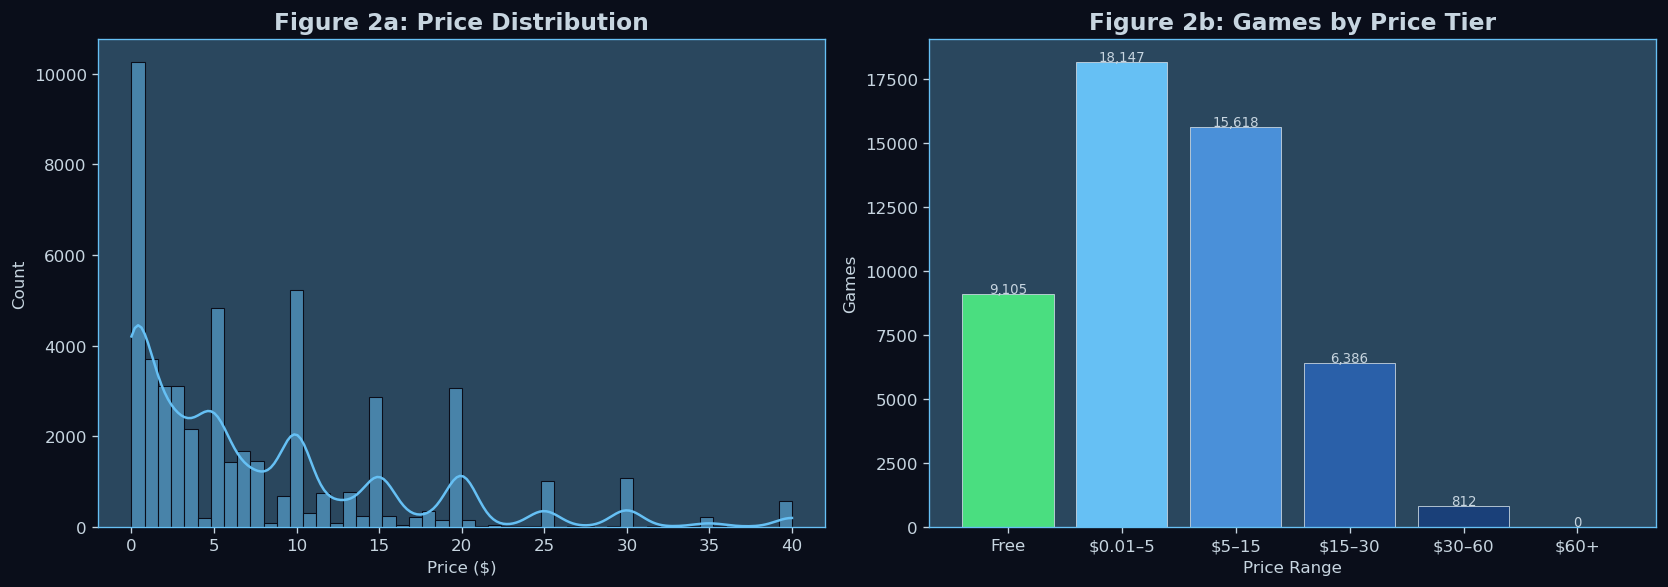

In [10]:
# ── Figure 2: Price Distribution ──
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(games[games['price_final']<70]['price_final'],
             bins=50, kde=True, color=STEAM_BLUE, ax=axes[0], edgecolor=STEAM_DARK)
axes[0].set_title('Figure 2a: Price Distribution')
axes[0].set_xlabel('Price ($)')

bins_labels = ['Free','$0.01–5','$5–15','$15–30','$30–60','$60+']
price_cats  = pd.cut(games['price_final'],bins=[-0.01,0,5,15,30,60,10000],labels=bins_labels)
price_counts = price_cats.value_counts().sort_index()
c = [STEAM_GREEN,STEAM_BLUE,'#4a90d9','#2a60a9','#1a4079',STEAM_PANEL]
bars = axes[1].bar(price_counts.index, price_counts.values, color=c, edgecolor=STEAM_LIGHT, linewidth=0.5)
axes[1].set_title('Figure 2b: Games by Price Tier')
axes[1].set_xlabel('Price Range')
axes[1].set_ylabel('Games')
for bar in bars:
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+30,
                 f'{int(bar.get_height()):,}', ha='center', fontsize=8)
plt.tight_layout()
plt.savefig('fig02_price_analysis.png', bbox_inches='tight')
plt.show()


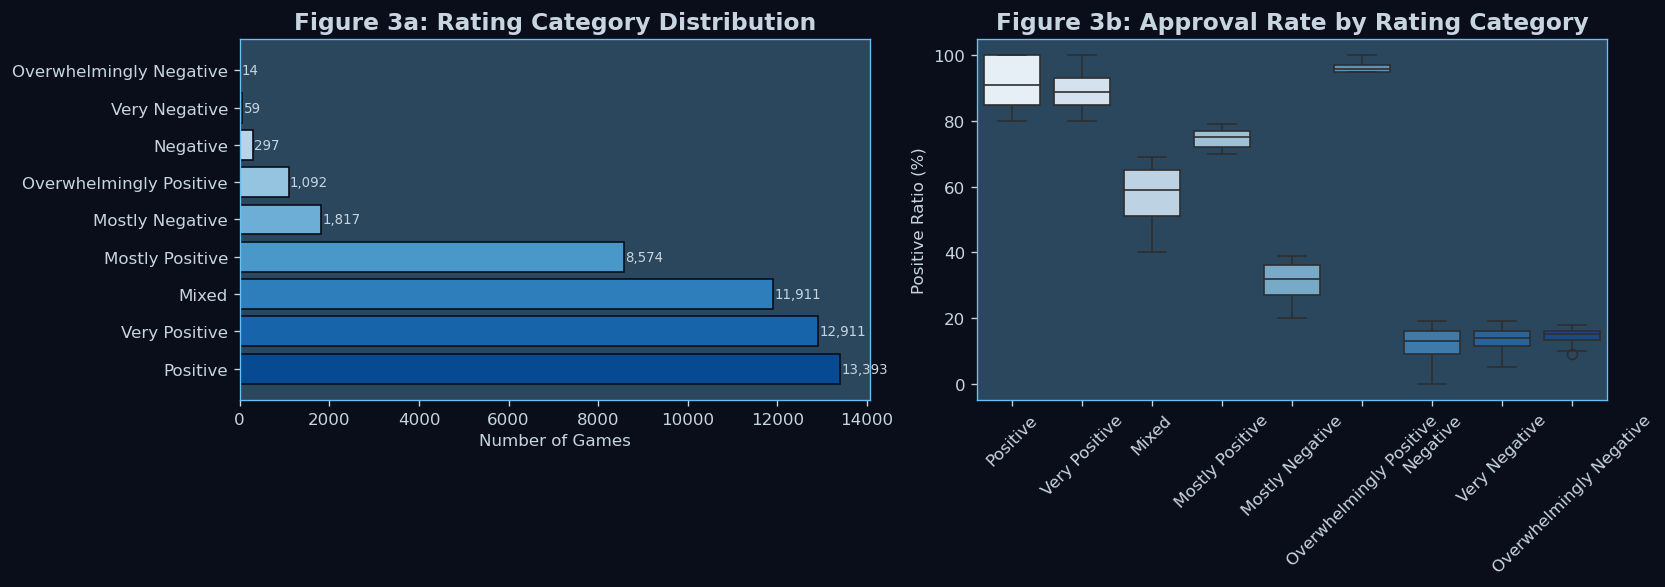

In [11]:
# ── Figure 3: Rating Distribution ──
fig, axes = plt.subplots(1,2,figsize=(14,5))
rating_counts = games['rating'].value_counts()
pal = sns.color_palette('Blues_r', len(rating_counts))

axes[0].barh(rating_counts.index, rating_counts.values, color=pal, edgecolor=STEAM_DARK)
axes[0].set_title('Figure 3a: Rating Category Distribution')
axes[0].set_xlabel('Number of Games')
for i,(idx,val) in enumerate(rating_counts.items()):
    axes[0].text(val+30, i, f'{val:,}', va='center', fontsize=8)

sns.boxplot(x='rating', y='positive_ratio', data=games, palette='Blues',
            ax=axes[1], order=rating_counts.index)
axes[1].set_title('Figure 3b: Approval Rate by Rating Category')
axes[1].set_xlabel('')
axes[1].set_ylabel('Positive Ratio (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig03_rating_analysis.png', bbox_inches='tight')
plt.show()


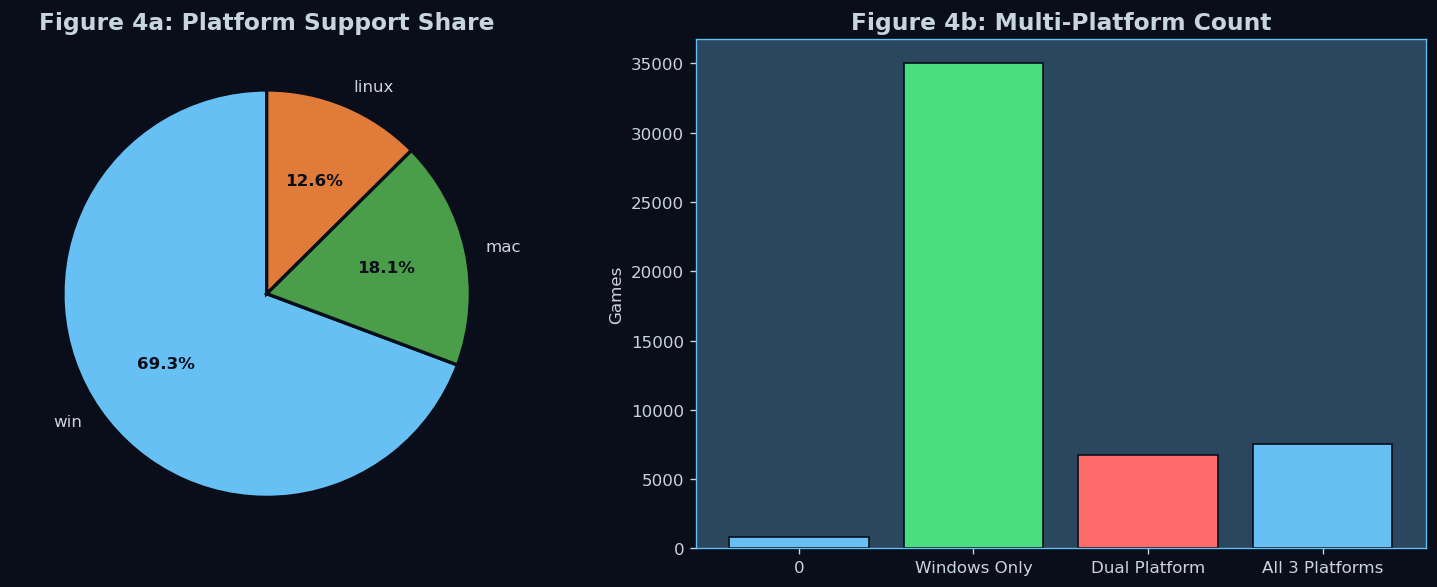

In [12]:
# ── Figure 4: Platform Support ──
fig, axes = plt.subplots(1,2,figsize=(13,5))
if plat_cols:
    plat_data = games[plat_cols].sum()
    wedges,texts,autotexts = axes[0].pie(
        plat_data, labels=plat_data.index, autopct='%1.1f%%',
        colors=[STEAM_BLUE,'#4a9e4a','#e07b39'],
        startangle=90, wedgeprops={'edgecolor':STEAM_DARK,'linewidth':2}
    )
    for t in autotexts: t.set_color(STEAM_DARK); t.set_fontweight('bold')
axes[0].set_title('Figure 4a: Platform Support Share')

if len(plat_cols)==3:
    games['num_platforms'] = games[plat_cols].sum(axis=1)
    plat_dist = games['num_platforms'].value_counts().sort_index()
    label_map = {1:'Windows Only', 2:'Dual Platform', 3:'All 3 Platforms'}
    axes[1].bar([label_map.get(i,str(i)) for i in plat_dist.index], plat_dist.values,
                color=[STEAM_BLUE,STEAM_GREEN,'#ff6b6b'], edgecolor=STEAM_DARK)
    axes[1].set_title('Figure 4b: Multi-Platform Count')
    axes[1].set_ylabel('Games')

plt.tight_layout()
plt.savefig('fig04_platform_analysis.png', bbox_inches='tight')
plt.show()


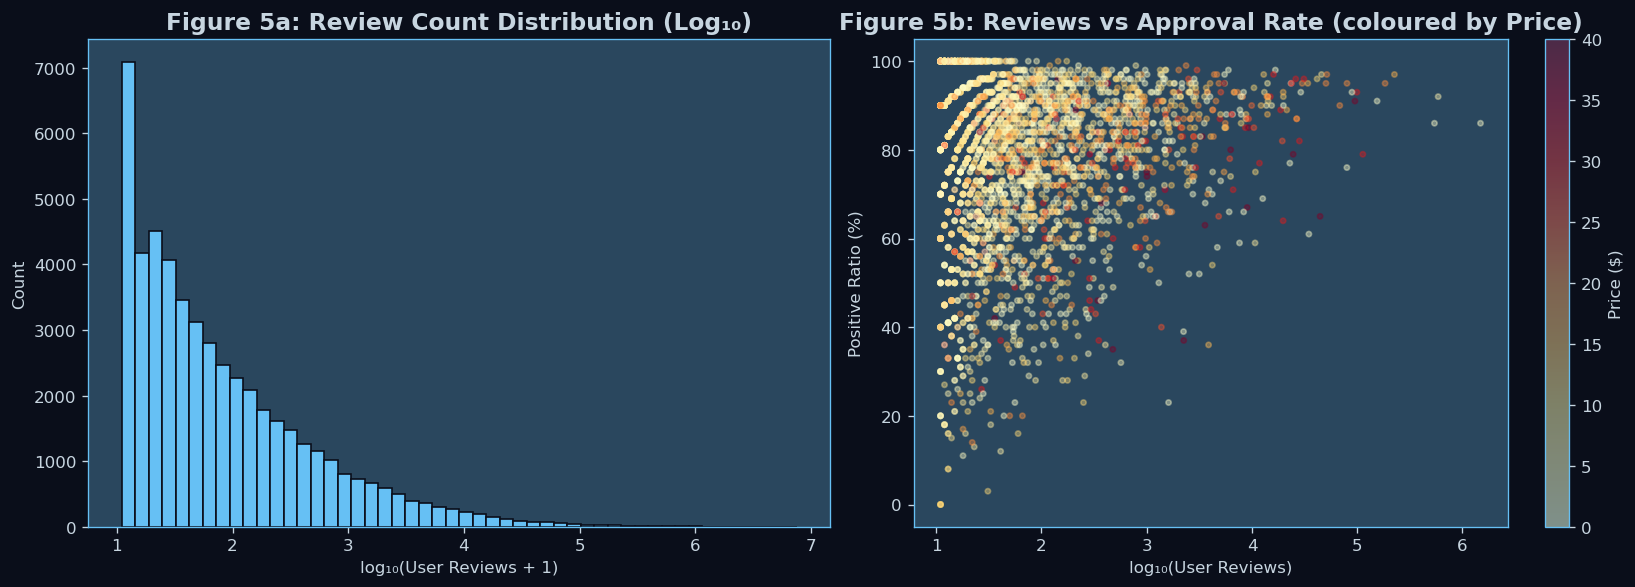

In [13]:
# ── Figure 5: Reviews Analysis ──
fig, axes = plt.subplots(1,2,figsize=(14,5))
review_data = games[games['user_reviews']>0]['user_reviews']
axes[0].hist(np.log10(review_data+1), bins=50, color=STEAM_BLUE, edgecolor=STEAM_DARK)
axes[0].set_title('Figure 5a: Review Count Distribution (Log₁₀)')
axes[0].set_xlabel('log₁₀(User Reviews + 1)')
axes[0].set_ylabel('Count')

sample = games.sample(min(3000,len(games)), random_state=42)
sc = axes[1].scatter(np.log10(sample['user_reviews']+1), sample['positive_ratio'],
                     c=sample['price_final'], cmap='YlOrRd', alpha=0.4, s=10)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Price ($)', color=STEAM_LIGHT)
axes[1].set_title('Figure 5b: Reviews vs Approval Rate (coloured by Price)')
axes[1].set_xlabel('log₁₀(User Reviews)')
axes[1].set_ylabel('Positive Ratio (%)')

plt.tight_layout()
plt.savefig('fig05_reviews_analysis.png', bbox_inches='tight')
plt.show()

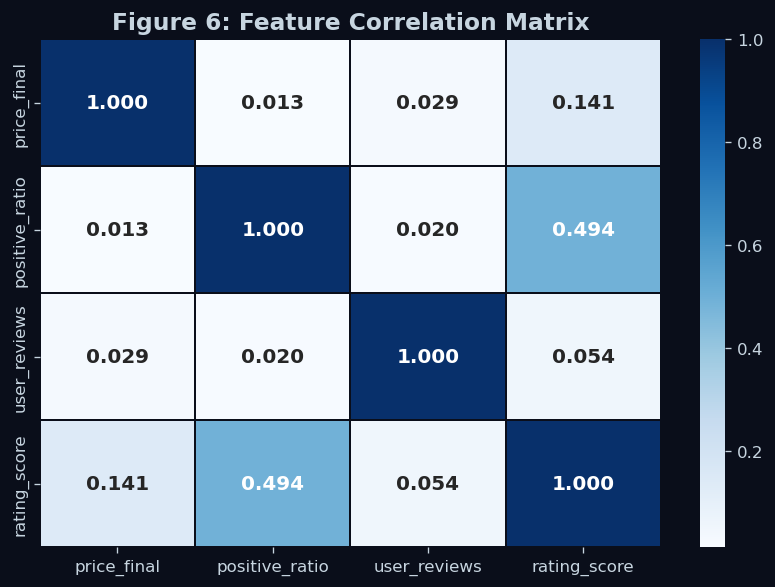

In [14]:
# ── Figure 6: Correlation Heatmap ──
num_cols = [c for c in ['price_final','positive_ratio','user_reviews','rating_score'] if c in games.columns]
corr = games[num_cols].corr()

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='Blues',
            linewidths=1, linecolor=STEAM_DARK,
            annot_kws={'size':12,'weight':'bold'}, ax=ax)
ax.set_title('Figure 6: Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('fig06_correlation_heatmap.png', bbox_inches='tight')
plt.show()

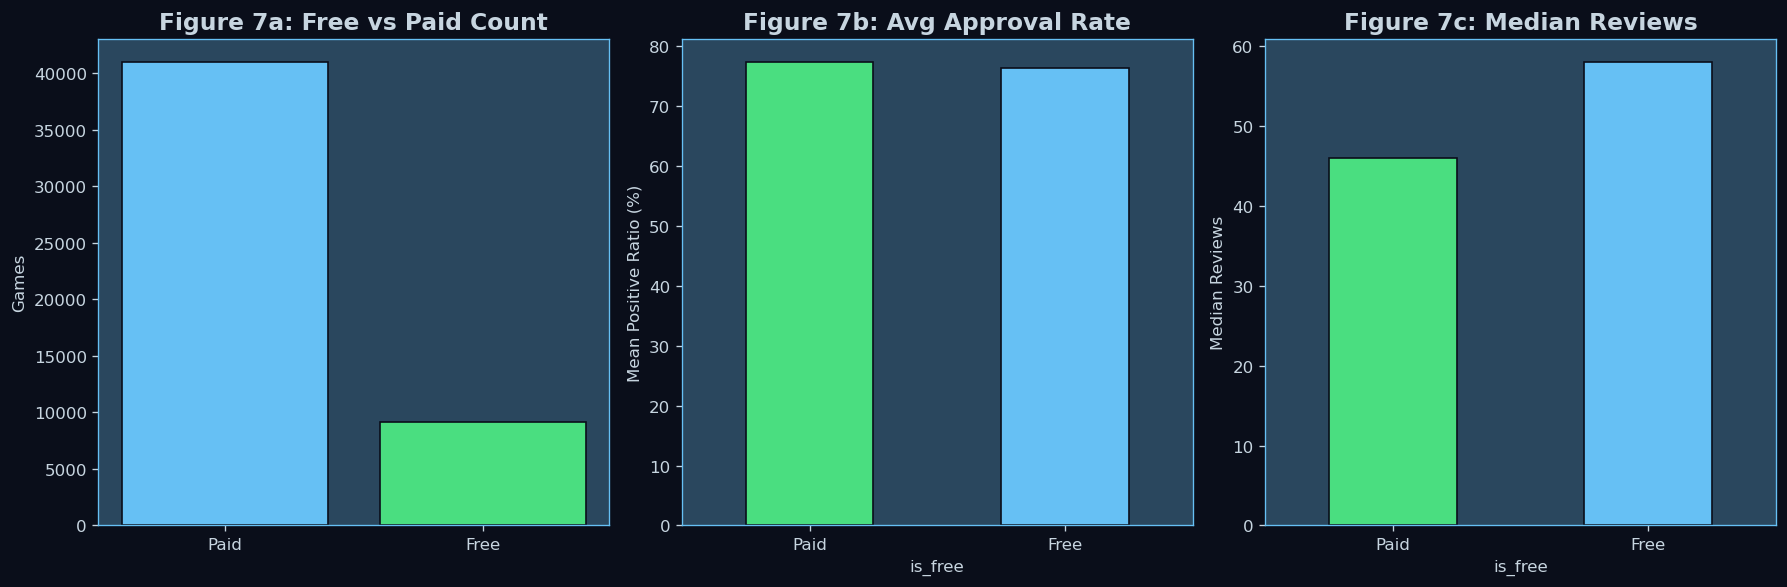

In [15]:
# ── Figure 7: Free vs Paid ──
games['is_free'] = games['price_final'] == 0
fig, axes = plt.subplots(1,3,figsize=(15,5))

counts = games['is_free'].value_counts()
axes[0].bar(['Paid','Free'],[counts.get(False,0),counts.get(True,0)],
            color=[STEAM_BLUE,STEAM_GREEN], edgecolor=STEAM_DARK)
axes[0].set_title('Figure 7a: Free vs Paid Count')
axes[0].set_ylabel('Games')

games.groupby('is_free')['positive_ratio'].mean().rename(index={True:'Free',False:'Paid'}).plot(
    kind='bar', ax=axes[1], color=[STEAM_GREEN,STEAM_BLUE], edgecolor=STEAM_DARK)
axes[1].set_title('Figure 7b: Avg Approval Rate')
axes[1].set_ylabel('Mean Positive Ratio (%)')
axes[1].tick_params(axis='x', rotation=0)

games.groupby('is_free')['user_reviews'].median().rename(index={True:'Free',False:'Paid'}).plot(
    kind='bar', ax=axes[2], color=[STEAM_GREEN,STEAM_BLUE], edgecolor=STEAM_DARK)
axes[2].set_title('Figure 7c: Median Reviews')
axes[2].set_ylabel('Median Reviews')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('fig07_free_vs_paid.png', bbox_inches='tight')
plt.show()


In [16]:
# ── Weighted Feature Engineering ──
print('Building hybrid feature strings...')

games['ai_features'] = (
    games['title'].astype(str) + ' ' +
    games['title'].astype(str) + ' ' +
    games['title'].astype(str) + ' ' +
    games['rating'].astype(str) + ' ' +
    games['rating'].astype(str) + ' ' +
    games['price_tier'].astype(str)
)

# ── TF-IDF Vectorization (sparse — memory efficient) ──
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=8000,      # larger vocab for 71K games
    ngram_range=(1, 2),     # unigrams + bigrams
    sublinear_tf=True,      # log(TF) dampening — better for skewed frequencies
    min_df=2                # ignore terms appearing in only 1 game
)

tfidf_matrix = tfidf.fit_transform(games['ai_features'])

print(f'TF-IDF matrix shape   : {tfidf_matrix.shape}')
print(f'Matrix type           : {type(tfidf_matrix)} (sparse — memory efficient)')
print(f'Stored elements       : {tfidf_matrix.nnz:,}')
print(f'Sparsity              : {100*(1 - tfidf_matrix.nnz / np.prod(tfidf_matrix.shape)):.2f}%')
print(f'Memory (MB)           : {tfidf_matrix.data.nbytes / 1e6:.1f} MB  ← vs ~37,000 MB for dense matrix')
print(f'Vocabulary size       : {len(tfidf.vocabulary_):,}')


Building hybrid feature strings...
TF-IDF matrix shape   : (50068, 8000)
Matrix type           : <class 'scipy.sparse._csr.csr_matrix'> (sparse — memory efficient)
Stored elements       : 356,703
Sparsity              : 99.91%
Memory (MB)           : 2.9 MB  ← vs ~37,000 MB for dense matrix
Vocabulary size       : 8,000


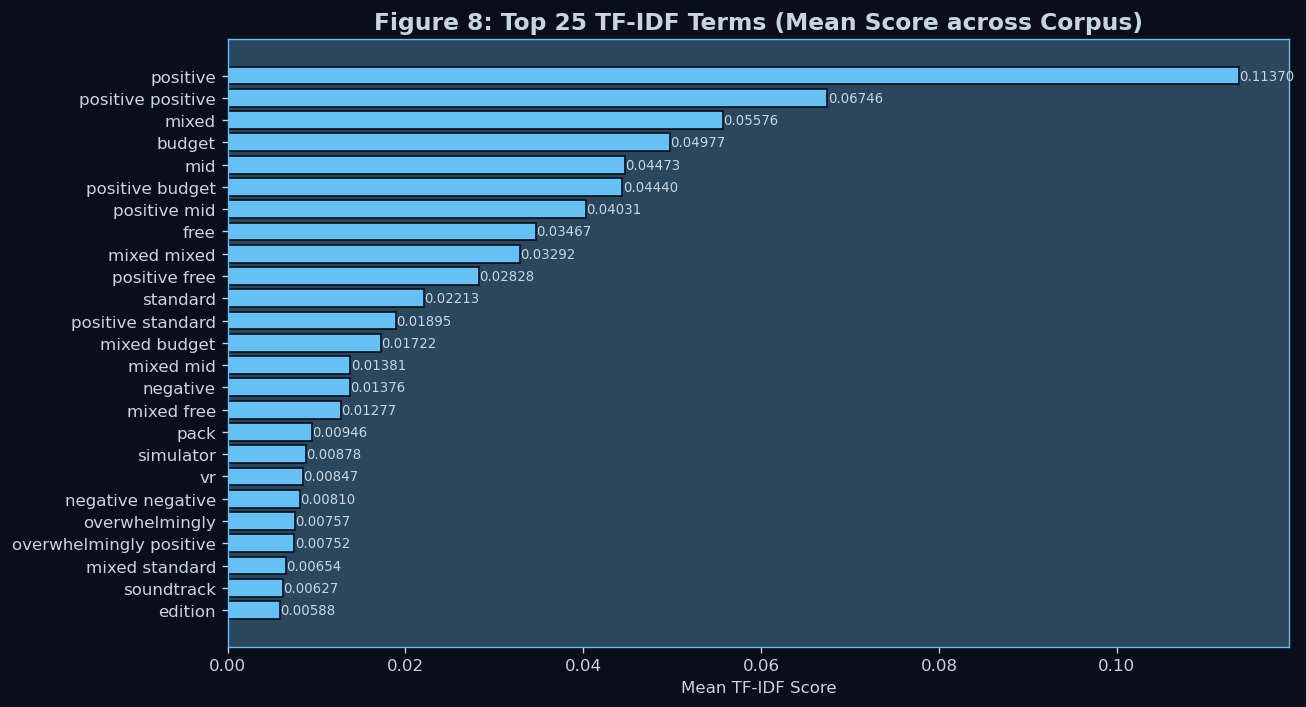

In [17]:
# ── Figure 8: Top TF-IDF Terms ──
feature_names = np.array(tfidf.get_feature_names_out())
tfidf_scores  = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_n   = 25
top_idx = tfidf_scores.argsort()[::-1][:top_n]

fig, ax = plt.subplots(figsize=(11,6))
bars = ax.barh(feature_names[top_idx][::-1], tfidf_scores[top_idx][::-1],
               color=STEAM_BLUE, edgecolor=STEAM_DARK)
ax.set_title(f'Figure 8: Top {top_n} TF-IDF Terms (Mean Score across Corpus)')
ax.set_xlabel('Mean TF-IDF Score')
for bar, score in zip(bars, tfidf_scores[top_idx][::-1]):
    ax.text(bar.get_width()+0.00003, bar.get_y()+bar.get_height()/2,
            f'{score:.5f}', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('fig08_tfidf_terms.png', bbox_inches='tight')
plt.show()
